## Load Libraries

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import os
import json
import argparse

import numpy as np
import pandas as pd
from time import time

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding


##Model-1 ; 1 Layer LSTM 

In [93]:
MODEL_DIR = '/content/drive/MyDrive/CharRNN/models/'

def save_weights(epoch, model):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    model.save_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

def load_weights(epoch, model):
    model.load_weights(MODEL_DIR+'weights.{}.h5'.format(epoch))

def build_model(batch_size, seq_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_len)))
    for i in range(1):
        model.add(LSTM(256, return_sequences=True, stateful=True))
        model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(vocab_size))) 
    model.add(Activation('softmax'))
    return model

if __name__ == '__main__':
    model = build_model(16, 64, 50)
    model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (16, 64, 512)             25600     
                                                                 
 lstm_32 (LSTM)              (16, 64, 256)             787456    
                                                                 
 dropout_32 (Dropout)        (16, 64, 256)             0         
                                                                 
 time_distributed_12 (TimeDi  (16, 64, 50)             12850     
 stributed)                                                      
                                                                 
 activation_21 (Activation)  (16, 64, 50)              0         
                                                                 
Total params: 825,906
Trainable params: 825,906
Non-trainable params: 0
_______________________________________________

## Model-2 ; 2 Layer LSTM 

In [176]:


MODEL_DIR = '/content/drive/MyDrive/CharRNN/models/'

def save_weights(epoch, model):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    model.save_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

def load_weights(epoch, model):
    model.load_weights(MODEL_DIR+'weights.{}.h5'.format(epoch))

def build_model(batch_size, seq_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_len)))
    for i in range(2):
        model.add(LSTM(256, return_sequences=True, stateful=True))
        model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(vocab_size))) 
    model.add(Activation('softmax'))
    return model

if __name__ == '__main__':
    model = build_model(16, 64, 50)
    model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (16, 64, 512)             25600     
                                                                 
 lstm_74 (LSTM)              (16, 64, 256)             787456    
                                                                 
 dropout_74 (Dropout)        (16, 64, 256)             0         
                                                                 
 lstm_75 (LSTM)              (16, 64, 256)             525312    
                                                                 
 dropout_75 (Dropout)        (16, 64, 256)             0         
                                                                 
 time_distributed_27 (TimeDi  (16, 64, 50)             12850     
 stributed)                                                      
                                                     

## Model -3 ;3 Layer LSTM 

In [145]:


MODEL_DIR = '/content/drive/MyDrive/CharRNN/models/'

def save_weights(epoch, model):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    model.save_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

def load_weights(epoch, model):
    model.load_weights(MODEL_DIR+'weights.{}.h5'.format(epoch))

def build_model(batch_size, seq_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_len)))
    for i in range(3):
        model.add(LSTM(256, return_sequences=True, stateful=True))
        model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(vocab_size))) 
    model.add(Activation('softmax'))
    return model

if __name__ == '__main__':
    model = build_model(16, 64, 50)
    model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (16, 64, 512)             25600     
                                                                 
 lstm_50 (LSTM)              (16, 64, 256)             787456    
                                                                 
 dropout_50 (Dropout)        (16, 64, 256)             0         
                                                                 
 lstm_51 (LSTM)              (16, 64, 256)             525312    
                                                                 
 dropout_51 (Dropout)        (16, 64, 256)             0         
                                                                 
 lstm_52 (LSTM)              (16, 64, 256)             525312    
                                                                 
 dropout_52 (Dropout)        (16, 64, 256)           

##Begin Training

In [146]:
DATA_DIR = '/content/drive/MyDrive/CharRNN/data'
LOG_DIR = '/content/drive/MyDrive/CharRNN/logs'

BATCH_SIZE = 16
SEQ_LENGTH = 64

In [147]:
class TrainLogger(object):
    def __init__(self, file):
        self.file = "/content/drive/MyDrive/CharRNN/logs/training_log.csv"
        self.epochs = 0
        with open(self.file, 'w') as writefile:
          writefile.write('epoch,loss,acc\n')

    def add_entry(self, loss, acc):
        self.epochs += 1
        s = '{},{},{}\n'.format(self.epochs, loss, acc)
        with open(self.file, 'a') as f:
            f.write(s)

In [148]:
def read_batches(T, vocab_size):
    length = T.shape[0]; #129,665
    batch_chars = int(length / BATCH_SIZE); # 8,104

    for start in range(0, batch_chars - SEQ_LENGTH, SEQ_LENGTH): # (0, 8040, 64)
        X = np.zeros((BATCH_SIZE, SEQ_LENGTH)) # 16X64
        Y = np.zeros((BATCH_SIZE, SEQ_LENGTH, vocab_size)) # 16X64X86
        for batch_idx in range(0, BATCH_SIZE): # (0,16)
            for i in range(0, SEQ_LENGTH): #(0,64)
                X[batch_idx, i] = T[batch_chars * batch_idx + start + i] # 
                Y[batch_idx, i, T[batch_chars * batch_idx + start + i + 1]] = 1
        yield X, Y

In [149]:
def train(text, epochs=100, save_freq=10):

    # character to index and vice-versa mappings
    char_to_idx = { ch: i for (i, ch) in enumerate(sorted(list(set(text)))) }
    print("Number of unique characters: " + str(len(char_to_idx))) #86

    #with open(os.path.join(DATA_DIR, 'char_to_idx.json'), 'w') as f:
    #    json.dump(char_to_idx, f)
    JSONDatafilePath = "/content/drive/MyDrive/CharRNN/data/char_to_idx.json"
    JSONDataFile = open(JSONDatafilePath, "w")
    json.dump(char_to_idx, JSONDataFile)

    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)

    #model_architecture
    model = build_model(BATCH_SIZE, SEQ_LENGTH, vocab_size)
    #model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    #Train data generation
    T = np.asarray([char_to_idx[c] for c in text], dtype=np.int32) #convert complete text into numerical indices

    print("Length of text:" + str(T.size)) #129,665

    steps_per_epoch = (len(text) / BATCH_SIZE - 1) / SEQ_LENGTH  

    log = TrainLogger('training_log.csv')

    for epoch in range(epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, epochs))
        
        losses, accs = [], []

        for i, (X, Y) in enumerate(read_batches(T, vocab_size)):
            
            print(X);

            loss, acc = model.train_on_batch(X, Y)
            print('Batch {}: loss = {}, acc = {}'.format(i + 1, loss, acc))
            losses.append(loss)
            accs.append(acc)

        log.add_entry(np.average(losses), np.average(accs))

        if (epoch + 1) % save_freq == 0:
            save_weights(epoch + 1, model)
            print('Saved checkpoint to', 'weights.{}.h5'.format(epoch + 1))



## Train Model 1 or 2 or 3 with 50 epochs

In [159]:
start = time()
if __name__ == '__main__':
    #parser = argparse.ArgumentParser(description='Train the model on some text.')
    #parser.add_argument('--input', default='/content/drive/MyDrive/CharRNN/data/input.txt', help='name of the text file to train from')
    #parser.add_argument('--epochs', type=int, default=100, help='number of epochs to train for')
    #parser.add_argument('--freq', type=int, default=10, help='checkpoint save frequency')
    #args = parser.parse_args()

    
    DatafilePath = "/content/drive/MyDrive/CharRNN/data/input.txt"
    DataFile = open(DatafilePath, "r")
    
    train(DataFile.read(), 50, 10)
model_time = time() - start

Streaming output truncated to the last 5000 lines.
 [62. 17. 60. ... 29. 60. 84.]
 [62. 17. 61. ... 62.  1. 35.]
 ...
 [84.  3. 32. ... 28. 70.  3.]
 [ 3. 31.  3. ... 58. 77. 58.]
 [60. 28. 84. ... 31. 17. 29.]]
Batch 7: loss = 0.5996744632720947, acc = 0.80078125
[[28. 84.  3. ...  1.  3. 34.]
 [ 3. 31.  3. ... 29. 60. 84.]
 [78. 71. 77. ... 25. 21. 14.]
 ...
 [28. 18.  1. ... 77. 77. 66.]
 [59. 58. 76. ... 29.  1. 28.]
 [ 1. 60. 17. ...  3. 28. 60.]]
Batch 8: loss = 0.6229537725448608, acc = 0.7958984375
[[ 3. 34. 18. ...  3. 34.  3.]
 [ 3. 31.  3. ...  1. 61. 17.]
 [23.  0. 38. ... 32. 70.  3.]
 ...
 [71. 64. 65. ... 30.  3. 58.]
 [34. 33. 84. ... 17. 25. 84.]
 [62.  1. 61. ...  1. 40. 78.]]
Batch 9: loss = 0.5866292119026184, acc = 0.8203125
[[64. 17. 64. ...  1. 34. 17.]
 [25. 84.  0. ... 38. 62. 79.]
 [62. 60. 28. ... 62. 61. 60.]
 ...
 [18.  1. 64. ... 33.  3. 58.]
 [ 0. 43. 25. ...  3. 29. 29.]
 [76. 66. 60. ...  3. 61. 17.]]
Batch 10: loss = 0.5466546416282654, acc = 0.8105468

In [160]:
print(model_time)

133.72306370735168


###Plot 

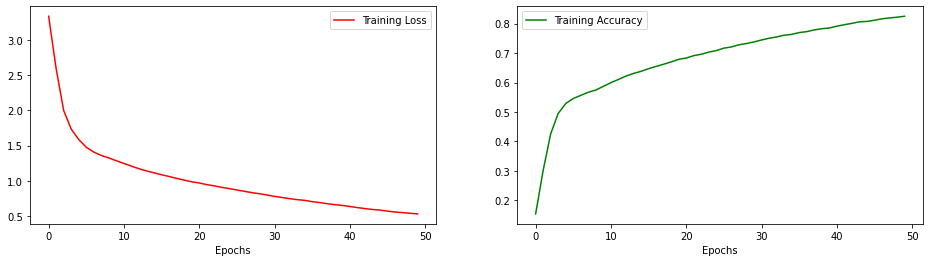

In [163]:

df_plot = pd.read_csv('/content/drive/MyDrive/CharRNN/logs/Model3_Epoch50.csv')

losses = df_plot['loss']
accs = df_plot['acc']
epochs = df_plot['epoch']

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], ['Loss', 'Accuracy'],['red','green'])):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("Epochs")
    plt.plot(range(50), metrics[0], label='Training {}'.format(metrics[1]),color='{}'.format(metrics[2]))
    plt.legend()
plt.show()

## Train Model 1, 2 and 3 with 100 epochs

In [177]:
start = time()
if __name__ == '__main__':
    #parser = argparse.ArgumentParser(description='Train the model on some text.')
    #parser.add_argument('--input', default='/content/drive/MyDrive/CharRNN/data/input.txt', help='name of the text file to train from')
    #parser.add_argument('--epochs', type=int, default=100, help='number of epochs to train for')
    #parser.add_argument('--freq', type=int, default=10, help='checkpoint save frequency')
    #args = parser.parse_args()

    
    DatafilePath = "/content/drive/MyDrive/CharRNN/data/input.txt"
    DataFile = open(DatafilePath, "r")
    
    train(DataFile.read(), 100, 10)
model_time = time() - start

Streaming output truncated to the last 5000 lines.
 [62. 17. 60. ... 29. 60. 84.]
 [62. 17. 61. ... 62.  1. 35.]
 ...
 [84.  3. 32. ... 28. 70.  3.]
 [ 3. 31.  3. ... 58. 77. 58.]
 [60. 28. 84. ... 31. 17. 29.]]
Batch 7: loss = 0.18955475091934204, acc = 0.939453125
[[28. 84.  3. ...  1.  3. 34.]
 [ 3. 31.  3. ... 29. 60. 84.]
 [78. 71. 77. ... 25. 21. 14.]
 ...
 [28. 18.  1. ... 77. 77. 66.]
 [59. 58. 76. ... 29.  1. 28.]
 [ 1. 60. 17. ...  3. 28. 60.]]
Batch 8: loss = 0.20542782545089722, acc = 0.9375
[[ 3. 34. 18. ...  3. 34.  3.]
 [ 3. 31.  3. ...  1. 61. 17.]
 [23.  0. 38. ... 32. 70.  3.]
 ...
 [71. 64. 65. ... 30.  3. 58.]
 [34. 33. 84. ... 17. 25. 84.]
 [62.  1. 61. ...  1. 40. 78.]]
Batch 9: loss = 0.1994907259941101, acc = 0.9296875
[[64. 17. 64. ...  1. 34. 17.]
 [25. 84.  0. ... 38. 62. 79.]
 [62. 60. 28. ... 62. 61. 60.]
 ...
 [18.  1. 64. ... 33.  3. 58.]
 [ 0. 43. 25. ...  3. 29. 29.]
 [76. 66. 60. ...  3. 61. 17.]]
Batch 10: loss = 0.19674669206142426, acc = 0.931640625

In [178]:
print(model_time)

218.02866005897522


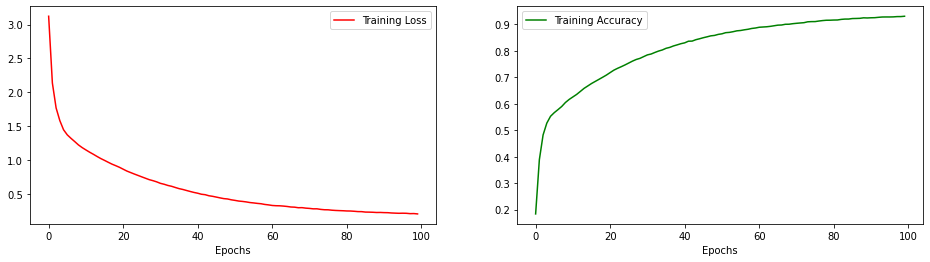

In [179]:

df_plot = pd.read_csv('/content/drive/MyDrive/CharRNN/logs/Model3_Epoch100.csv')

losses = df_plot['loss']
accs = df_plot['acc']
epochs = df_plot['epoch']

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], ['Loss', 'Accuracy'],['red','green'])):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("Epochs")
    plt.plot(range(100), metrics[0], label='Training {}'.format(metrics[1]),color='{}'.format(metrics[2]))
    plt.legend()
plt.show()


# Testing 

In [180]:
def build_sample_model(vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(1, 1)))
    for i in range(2):
        model.add(LSTM(256, return_sequences=(i != 2), stateful=True))
        model.add(Dropout(0.2))

    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    return model

In [181]:
JSONDatafilePath = '/content/drive/MyDrive/CharRNN/data/char_to_idx.json'
#JSONDataFile = 
with open(JSONDatafilePath, "r") as f:
  #print(f)
  char_to_idx = json.loads(f.read())

In [182]:


def sample(epoch, header, num_chars):
    MODEL_DIR = '/content/drive/MyDrive/CharRNN/models/'
    JSONDatafilePath = '/content/drive/MyDrive/CharRNN/data/char_to_idx.json'
    JSONDataFile = open(JSONDatafilePath, "r")
    with  JSONDataFile as f:
        char_to_idx = json.loads(f.read())
    
    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)
    model = build_sample_model(vocab_size)
    load_weights(epoch, model)
    model.save(MODEL_DIR+'model.{}.h5'.format(epoch))

    sampled = [char_to_idx[c] for c in header]
    print(sampled)
    

    for i in range(num_chars):
        batch = np.zeros((1, 1))
        if sampled:
            batch[0, 0] = sampled[-1]
        else:
            batch[0, 0] = np.random.randint(vocab_size)
        result = model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(vocab_size), p=result)
        sampled.append(sample)

    return ''.join(idx_to_char[c] for c in sampled)



## Generate New Music

In [183]:
if __name__ == '__main__':
    
    print(sample(100, '', 512))

[]
d ue
Y:Sip 1984, via Phil Rowe
M:6/8
K:A
E|"A"A2A "E"GAB|"A"A2c c2e|"Bm"f2B E2c|B2c -d2B|"A"c2e EAc|
"D"d2d dcd|"A"e2A A2e|"D"fga agf|"A"ecA Ace|
"A7"Ace f2e|"D"fgf fed|"A"cAA A2e|"D"fgf fed|"A"efe c2A|
"D"fga afd|"A"Aea agf|"A"ecA EAc|"E7"dBG "A"A2:|


X: 221
T:Oandy Jig
% Nottingham Music Database
S:Kevin Briggs, via EF
Y:AB
M:6/8
K:D
P:A
f/2g/2|"D"aba "A7/e"faf|"D/f+"dfd "G"dBG|"D"FAA "G"GAB|
"A"c3 cAA|"D"AdA fed|"A"c2c cBA|"G"Bcd "A"ecA|
"D"dcd "A7"edc|"D"ded dAF|"Em"GBB "D"AFA|
"G"Bcd "D"Acf|"G"edc "D"
